# This notebook shows how to load and use the provided model. 
#### It shows how to calculate and plot:
* Predictions
* Deexplainer contribution scores
* In silico saturation mutagenesis
#### DeepFlyBrain is provided in ./models/deepflybrain
#### The model can be downloaded from Zenodo, which is used by Kipoi database:
* DeepFlyBrain: https://zenodo.org/records/5153337


### General imports


In [1]:
import sys  
import os
import pickle
import utils
import numpy as np
import scipy
import tensorflow as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use("default")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### Loading DeepFlyBrain data to be used for the initialization of shap.DeepExplainer

In [2]:
print('Loading data...')
f = open('./data/deepflybrain/DeepFlyBrain_nonAugmented_data.pkl', "rb")
nonAugmented_data_dict = pickle.load(f)
f.close()

Loading data...


### Loading the model and initializing shap.DeepExplainer


In [3]:
print('Loading model...')
import shap
tf.disable_eager_execution()
rn=np.random.choice(nonAugmented_data_dict["train_data"].shape[0], 250, replace=False)
model_dict = {}
exp_dict = {} 

name = "DeepFlyBrain"
model_json_file = "models/deepflybrain/model.json"
model_hdf5_file = "models/deepflybrain/model_epoch_83.hdf5"
model_dict[name] = utils.load_model(model_json_file, model_hdf5_file)
exp_dict[name] = shap.DeepExplainer((model_dict[name].inputs, model_dict[name].layers[-1].output), nonAugmented_data_dict["train_data"][rn])


Loading model...


In [4]:
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

### snpf enhancer sequence

In [5]:
snpf_onehot = utils.one_hot_encode_along_row_axis("CTGTTATCAAAGGGTTGAGACTGTCGTTCGGTTCCGAAATTTTAAAGCATATTTTTAGCTTTAACCTTACACATTTATCGGCGGAAAAAAGGGGAGGGATGACCAGATGGCCAGATGGCCATCCGAAGTGGGCGTGCCAGATTTAACGACTTTAAGGCACGTTTAAGTGAGCAAATATTGACCAGGTGATGGACTGGACCAAGGATGCAGCACGGGAGCACAAGCTGGAGCAGGTGCCGTCCAGCATTTTGACTAATTGACCTGCGGCCACCAGATGATGGCAGTGATAATCCCGCCCGAGTGCGAGTAGTTCCATGCGAACGTACCGAACCCCAAGGCAACCTATTAATAAAACCAGAGAAATTCTCACGCTTAATTAAGCTATCGATTCGTGGCTGAAAAAATCAAAGAAGAGATAAACGAATTGAAGTTTGCAGGCGATTTGAAAGCGAAAGCTGAAAGACAAATTGCGGGGAGTGCGAGCCAATGGTAATCAATCG")

### Calculating and plotting nucleotide contribution scores and in silico saturation mutagenesis values
### using the DeepFlyBrain model and snpf enhancer

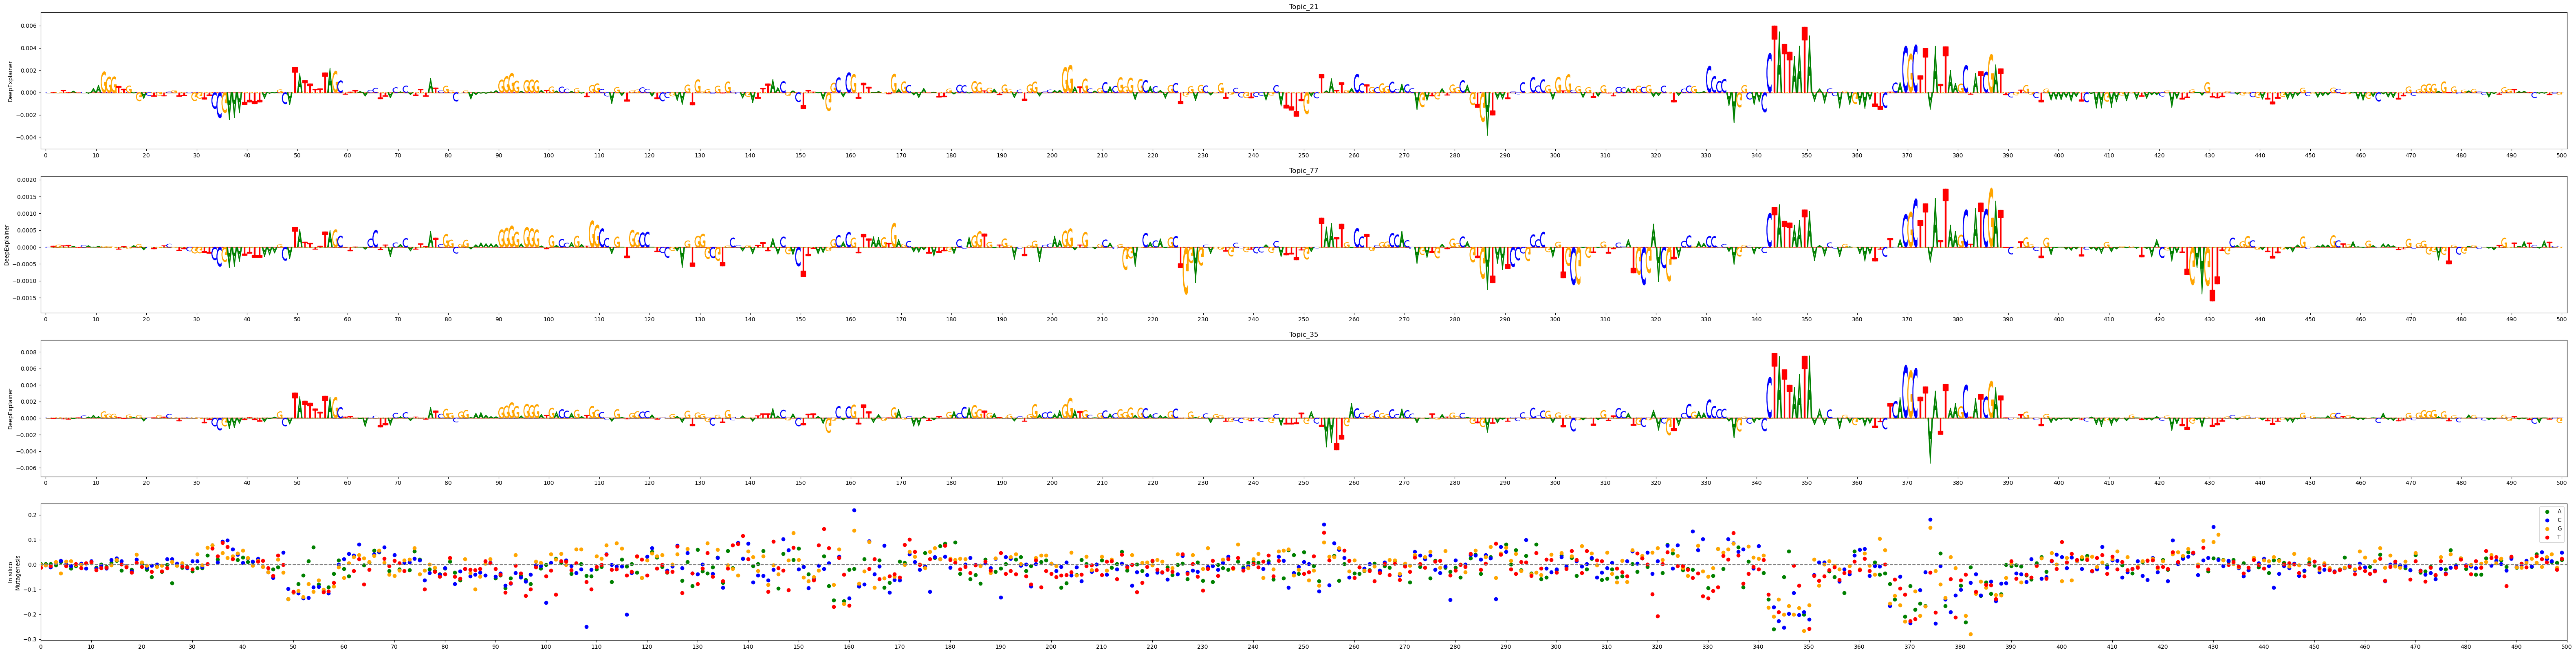

In [8]:
onehot_seq = np.copy(snpf_onehot)
ntrack = 4
fig = plt.figure(figsize=(80,ntrack*5))
ax1 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=onehot_seq, class_no = 21)
ax2 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=onehot_seq, class_no = 77)
ax3 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=3, seq_onehot=onehot_seq, class_no = 35)
_ = utils.plot_mutagenesis_givenax(model=model_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=4, seq_onehot=onehot_seq, class_no = 35)
#plt.savefig("tmp/snpf.pdf")


### Plotting prediction scores on IRF4 enhancer

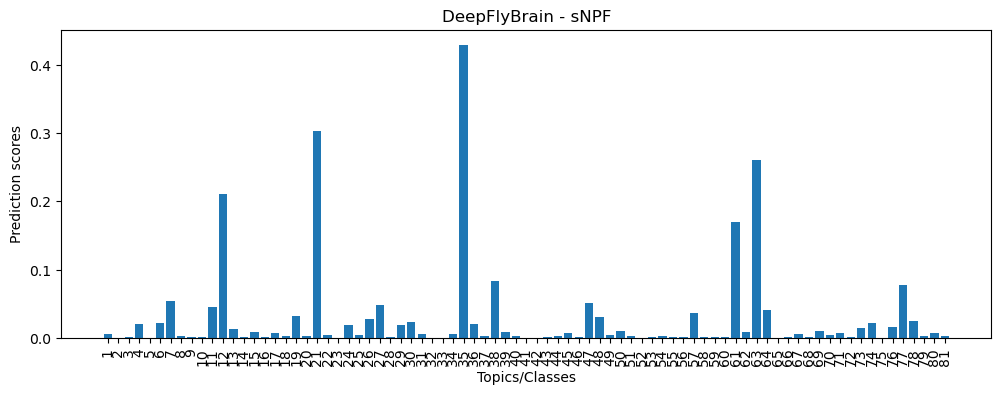

In [10]:
onehot_seq = np.copy(snpf_onehot)
prediction = model_dict["DeepFlyBrain"].predict([onehot_seq,onehot_seq[:,::-1,::-1]])

plt.figure(figsize=(12,4))
plt.bar(range(len(prediction[0])),prediction[0])
plt.title("DeepFlyBrain - sNPF")
plt.xlabel("Topics/Classes")
plt.ylabel("Prediction scores")
_ = plt.xticks(range(len(prediction[0])),range(1,len(prediction[0])+1),rotation=90)